In [1]:
!git clone https://github.com/huggingface/diffusers.git
!pip install ./diffusers
!pip install -U -r ./diffusers/examples/dreambooth/requirements.txt

Cloning into 'diffusers'...
remote: Enumerating objects: 47658, done.
remote: Counting objects: 100% (1496/1496), done.
remote: Compressing objects: 100% (694/694), done.
remote: Total 47658 (delta 971), reused 1091 (delta 677), pack-reused 46162
Receiving objects: 100% (47658/47658), 31.87 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (35142/35142), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 589.5 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 kB 9.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [52]:
%reset -f

In [53]:
!accelerate config default --mixed_precision fp16


Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [1]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()  # Force garbage collection

!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv


name, memory.total [MiB], memory.free [MiB]
NVIDIA GeForce RTX 3090, 24576 MiB, 24257 MiB


In [2]:
import os
os.environ['MODEL_NAME'] = 'CompVis/stable-diffusion-v1-4'
os.environ['INSTANCE_DIR'] = './bash_images'
os.environ['OUTPUT_DIR'] = './dreambooth/sd_aiconos-model-v1-2_400'

In [56]:

!accelerate launch ./diffusers/examples/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of brk1" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=300

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
12/12/2023 21:43:50 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'variance_type', 'timestep_spacing', 'prediction_type', 'sample_max_value', 'clip_sample_range', 'thresholding'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'norm_num_groups'} was not found in config. Values will be initialized to default values.
{'upcast_attention', 'only_cross_attention', 'resnet_skip_time_act', 'dropout', 'conv_out_kernel', 'encoder_hid_dim_type', 'time_embedding_type', 'class_embeddings_c

In [57]:
# from diffusers import StableDiffusionPipeline
# import torch

# model_id = "./dreambooth/sd_aiconos-model-v1-2_400"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

# prompt = "A photo of bash walking"
# image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

# image.save("dog-bucket.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

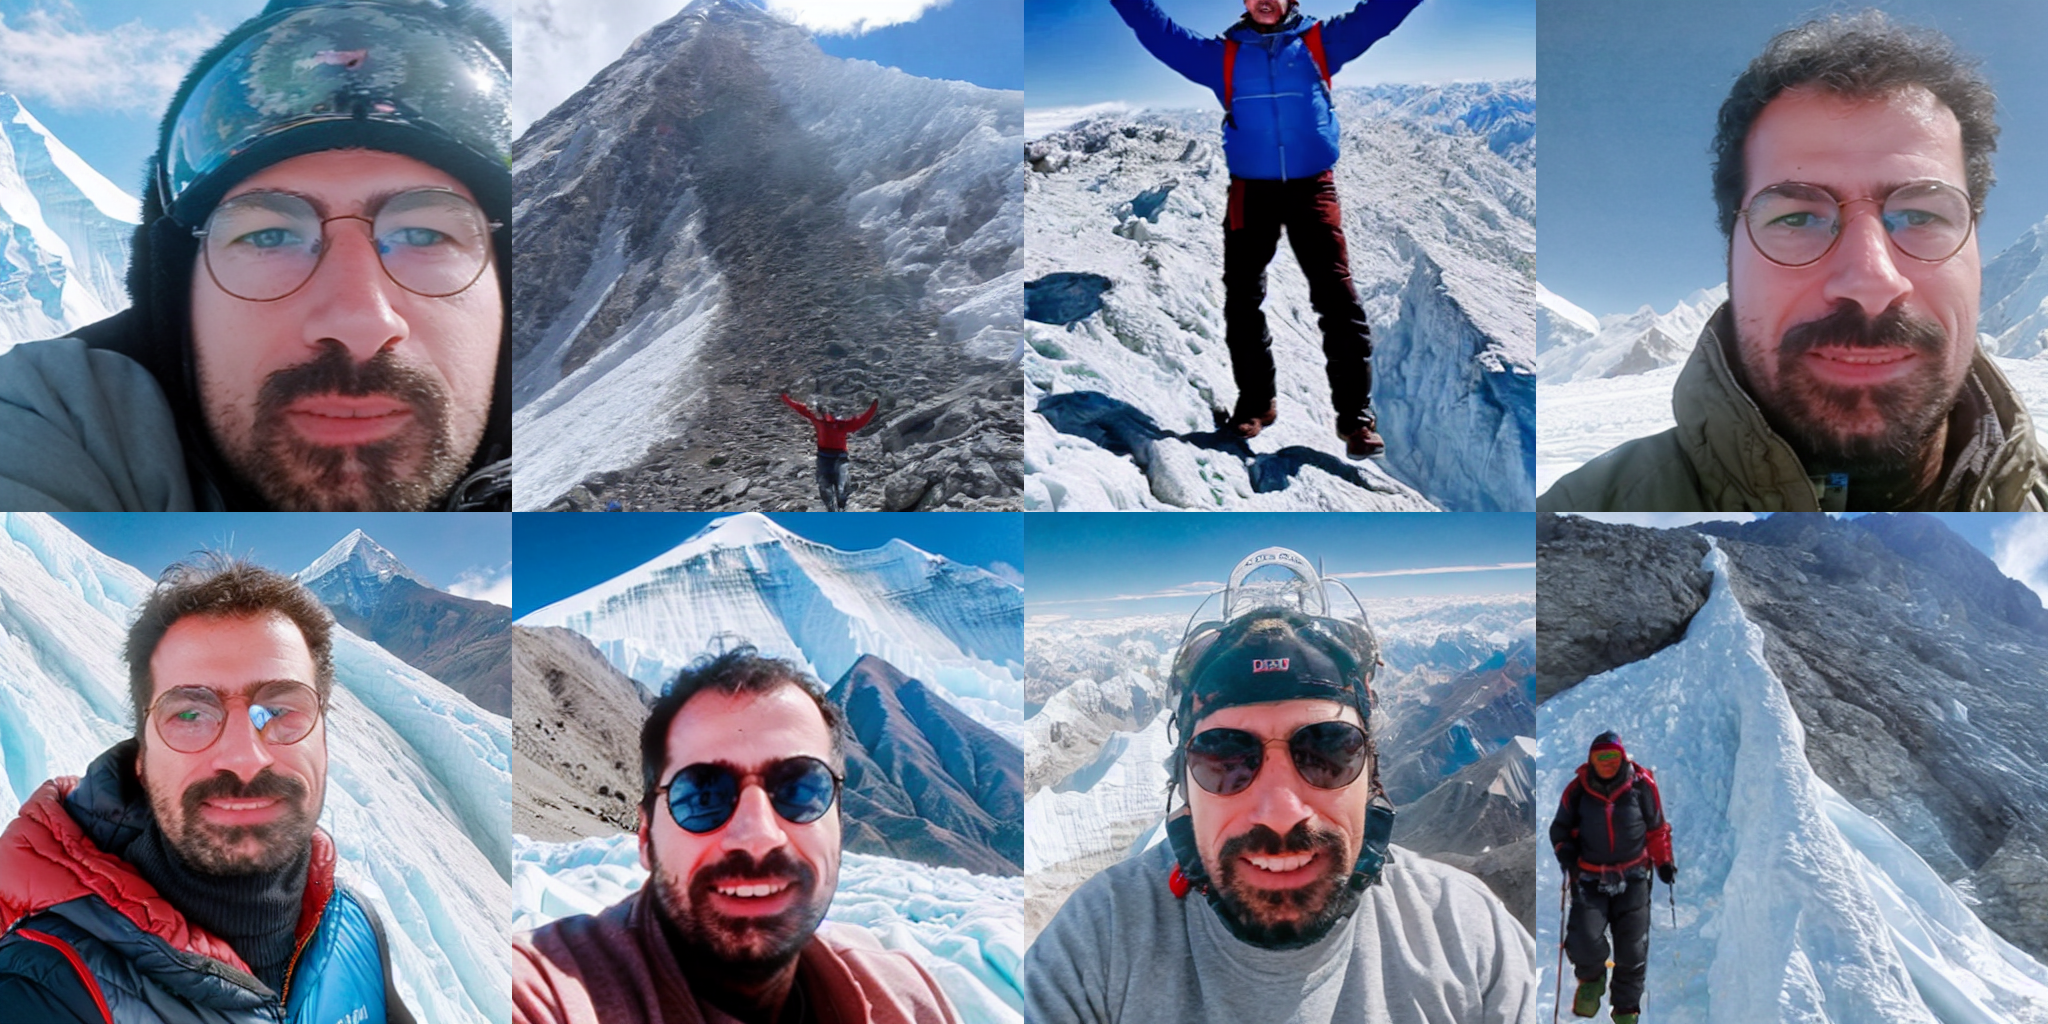

In [ ]:
%reset -f
from diffusers import StableDiffusionPipeline
from PIL import Image
import torch
torch.cuda.empty_cache()
seed = 142
torch.manual_seed(seed)
model_id = "./dreambooth/black_background_run32"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")
# pipe_base = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-2")
pipe.to("cuda")
# pipe_base.to("cuda")


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

prompt = "A photo of brk1 face on mount Everest"
# prompt = "A photo of brk1 face as bozo th clown"
# prompt = "A photo of brk1 face in a top gun pilot gear"

# Run inference using ChatGPT prompts to acquire 4 image panels
num_inference_steps=50
image1 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image1.save("tuned_lego_panel_1.png")
image2 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image2.save("tuned_lego_panel_1.png")
image3 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image3.save("tuned_lego_panel_1.png")
image4 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image4.save("tuned_lego_panel_1.png")
image5 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image5.save("tuned_lego_panel_1.png")
image6 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image6.save("tuned_lego_panel_1.png")
image7 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image7.save("tuned_lego_panel_1.png")
image8 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image8.save("tuned_lego_panel_1.png")
all_images = [image1,image2,image3,image4,image5,image6,image7,image8]
grid = image_grid(all_images, rows=2, cols=4)
grid

In [1]:
pipe.push_to_hub('stable_diffusion_fine_tune_multiple_images_black_background_1600_training_steps')

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

'https://huggingface.co/SpongeBash/stable_diffusion_fine_tune_multiple_images_black_background_1600_training_steps/tree/main/'

In [22]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [2]:
prompt = "A photo of brk1 smiling in a space suit"
# Run inference using ChatGPT prompts to acquire 4 image panels
num_inference_steps=50
image1 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image1.save("tuned_lego_panel_1.png")
image2 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image2.save("tuned_lego_panel_1.png")
image3 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image3.save("tuned_lego_panel_1.png")
image4 = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image4.save("tuned_lego_panel_1.png")

all_images = [image1,image2,image3,image4]
grid = image_grid(all_images, rows=1, cols=4)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

NameError: name 'image_grid' is not defined

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

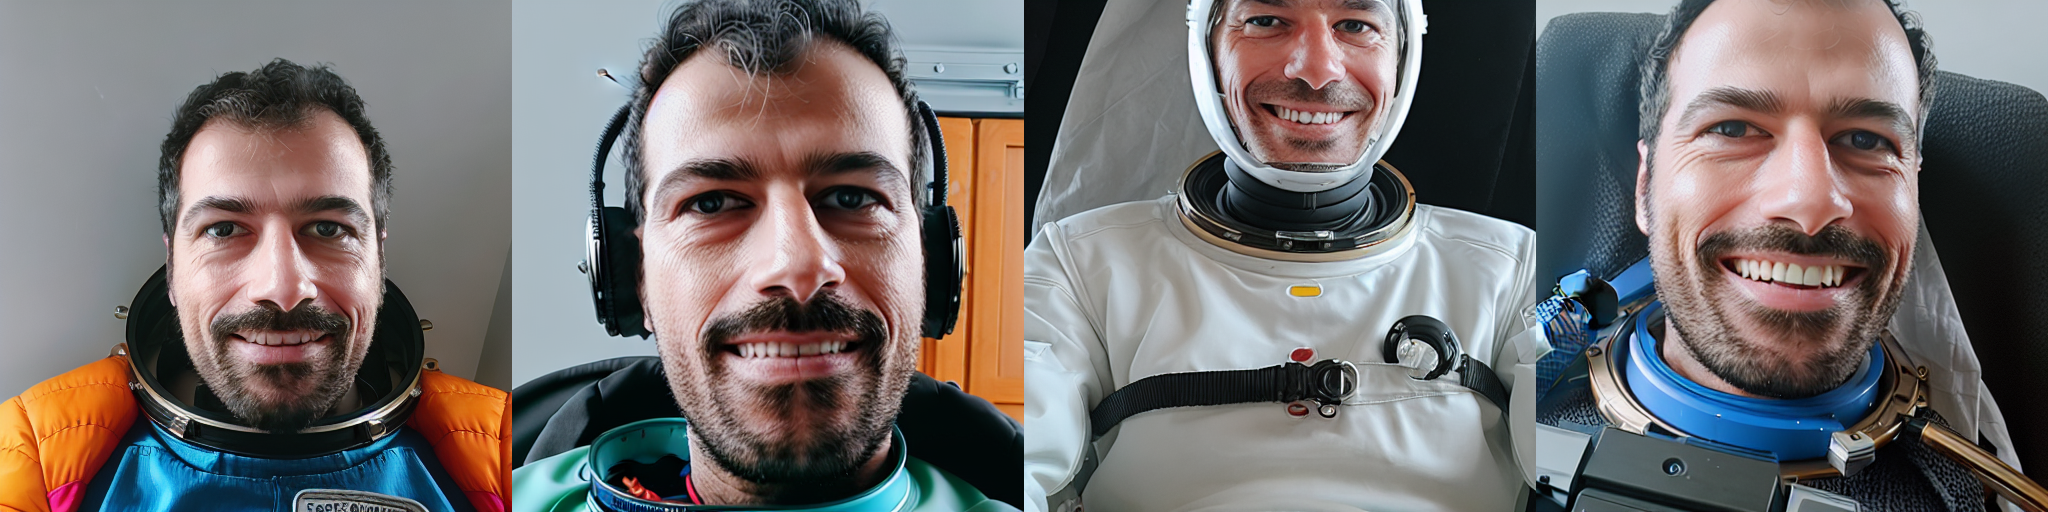

In [5]:
import plot_grid
model_id = f"./dreambooth/run{20}"
grid = plot_grid.plotting_grid(model_id)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

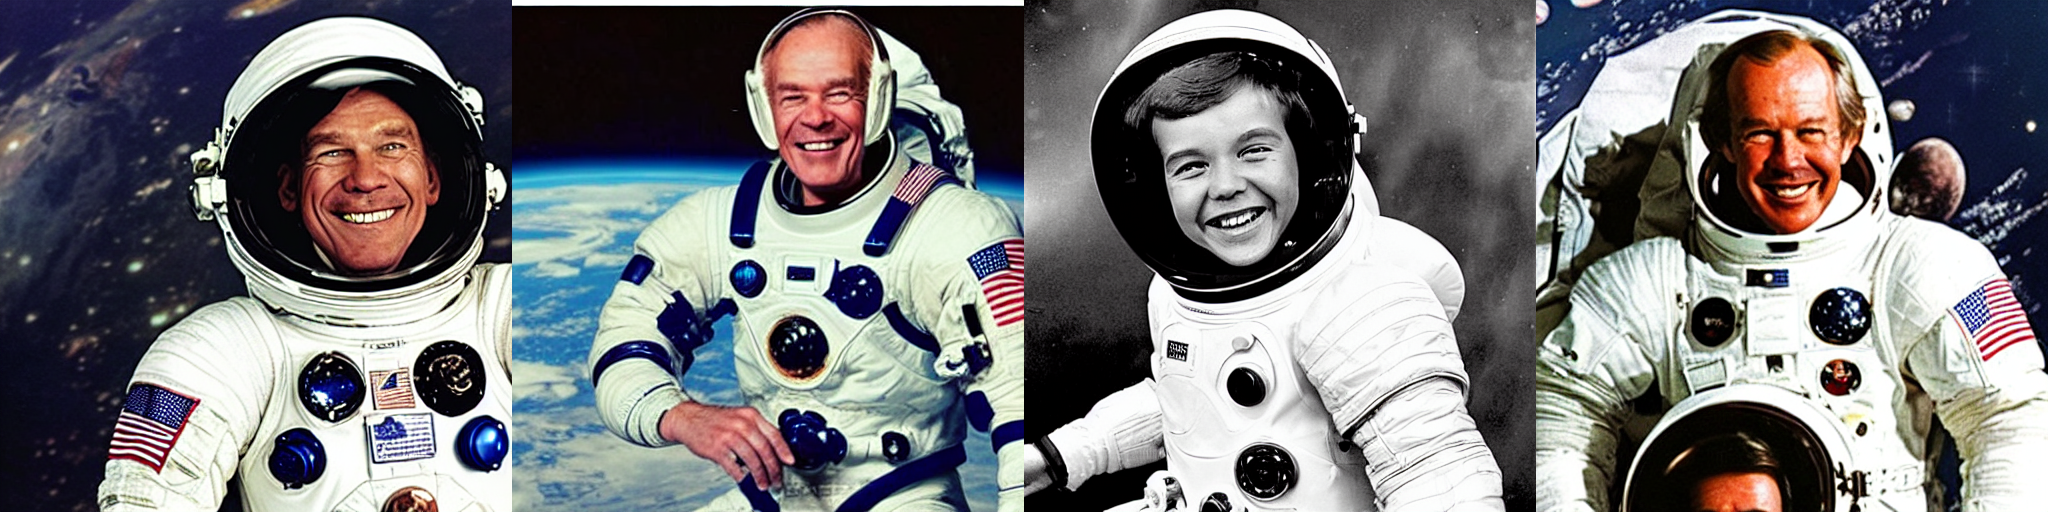

In [24]:
prompt = "A photo of brk1 smiling in a space suit"
# Run inference using ChatGPT prompts to acquire 4 image panels
num_inference_steps=50
image1 = pipe_base(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image1.save("tuned_lego_panel_1.png")
image2 = pipe_base(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image2.save("tuned_lego_panel_1.png")
image3 = pipe_base(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image3.save("tuned_lego_panel_1.png")
image4 = pipe_base(prompt, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]
image4.save("tuned_lego_panel_1.png")

all_images = [image1,image2,image3,image4]
grid = image_grid(all_images, rows=1, cols=4)
grid

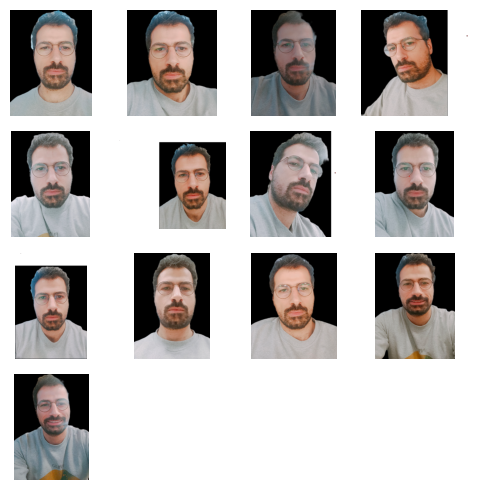

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
image_files = os.listdir('./bash_images')

num_images = len(image_files)
all_images = []
for image in image_files:
    
    all_images.append(np.array(Image.open(f'./bash_images/{image}')))
    
def plot_images(images, max_images_per_row=4):
    num_images = len(images)
    num_rows = int(np.ceil(num_images / max_images_per_row))

    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5,5), squeeze = False)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')  # Hide axis
        if i < num_images:
            ax.imshow(images[i])

    plt.tight_layout()
    plt.show()



plot_images(all_images)


In [53]:
all_images[0].size()

torch.Size([4608, 2592, 3])